## Looking for bias in the error

In this notebook we are looking at whether there is a bias in the mean error for
several lossy compressors, including 3 varients of the the zfp compressor. This
relates to the work in:

Dorit M. Hammerling, Allison H. Baker, Alexander Pinard, Peter Lindstrom, "A
collaborative effort to improve lossy compression for climate data,” in 2019
IEEE/ACM 5th International Workshop on Data Analysis and Reduction for Big
Scientific Data (DRBSD-5), Denver, CO, USA, 2019, pp. 16-22
(doi:10.1109/DRBSD-549595.2019.00008).

In particular, ZFP 0.5.3 shows a bias that we do not see with the newer varients
ZFP-beta and ZFP-round. The sample data resides on NCAR's glade storage, and we
use the NCAR Jupyter hub.

First we setup the environment and start a dask cluster.


In [1]:
#Make sure you are using the cmpi6-2019.10 kernel 

#Add ldcpy root to system path (MODIFY FOR YOUR LDCPY CODE LOCATION)
import sys
sys.path.insert(0,'/glade/u/home/abaker/repos/ldcpy')
import ldcpy

#Display output of plots directly in Notebook
%matplotlib inline
#Automatically reload module if it is editted
%reload_ext autoreload
%autoreload 2

#silence warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster, PBSCluster

# Casper
#cluster = SLURMCluster(
#    memory="40GB", cores=4, processes=1, walltime="00:60:00", project="NIOW0001"
#)

# Cheyenne
cluster = PBSCluster(
    queue="regular",
    walltime="02:00:00",
    project="NIOW0001",
    memory="109GB",
    resource_spec="select=1:ncpus=9:mem=109GB",
    cores=36,
    processes=9,
)

# scale as needed
cluster.adapt(minimum_jobs=1, maximum_jobs=35)
cluster

In [3]:
# Connect client to the remote dask workers
client = Client(cluster)
client

Client Scheduler: tcp://10.148.10.15:36181 Dashboard: https://jupyterhub.ucar.edu/ch/user/apinard/proxy/37595/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
# load the first 86 years of daily surface temperature (TS) data - this has been compressed with fpzip
col_TS_lens = ldcpy.open_datasets(
    ["TS"],
    [
        "/glade/p/cisl/asap/ldcpy_sample_data/lens/orig/TS.daily.19200101-20051231.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/lens/lossy/c.TS.daily.19200101-20051231.nc",
    ],
    ["orig", "fpzip"],
    chunks={"time": 500},
)
col_TS_lens

dataset size in GB 13.89



,Array,Chunk
Bytes,13.89 GB,110.59 MB
Shape,"(2, 31390, 192, 288)","(1, 500, 192, 288)"
Count,380 Tasks,126 Chunks
Type,float32,numpy.ndarray


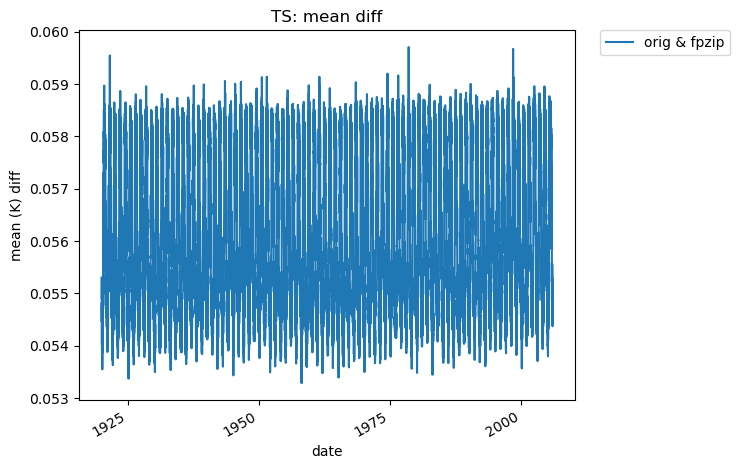

In [5]:
# Time-series plot of TS mean in ds orig dataset, grouped by day of year
ldcpy.plot(
    col_TS_lens,
    "TS",
    sets=["orig", "fpzip"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

That the above error is all positive makes sense because fpzip truncates -
meaning that it will be less than the original. We can see that in this spatial
plot as well.


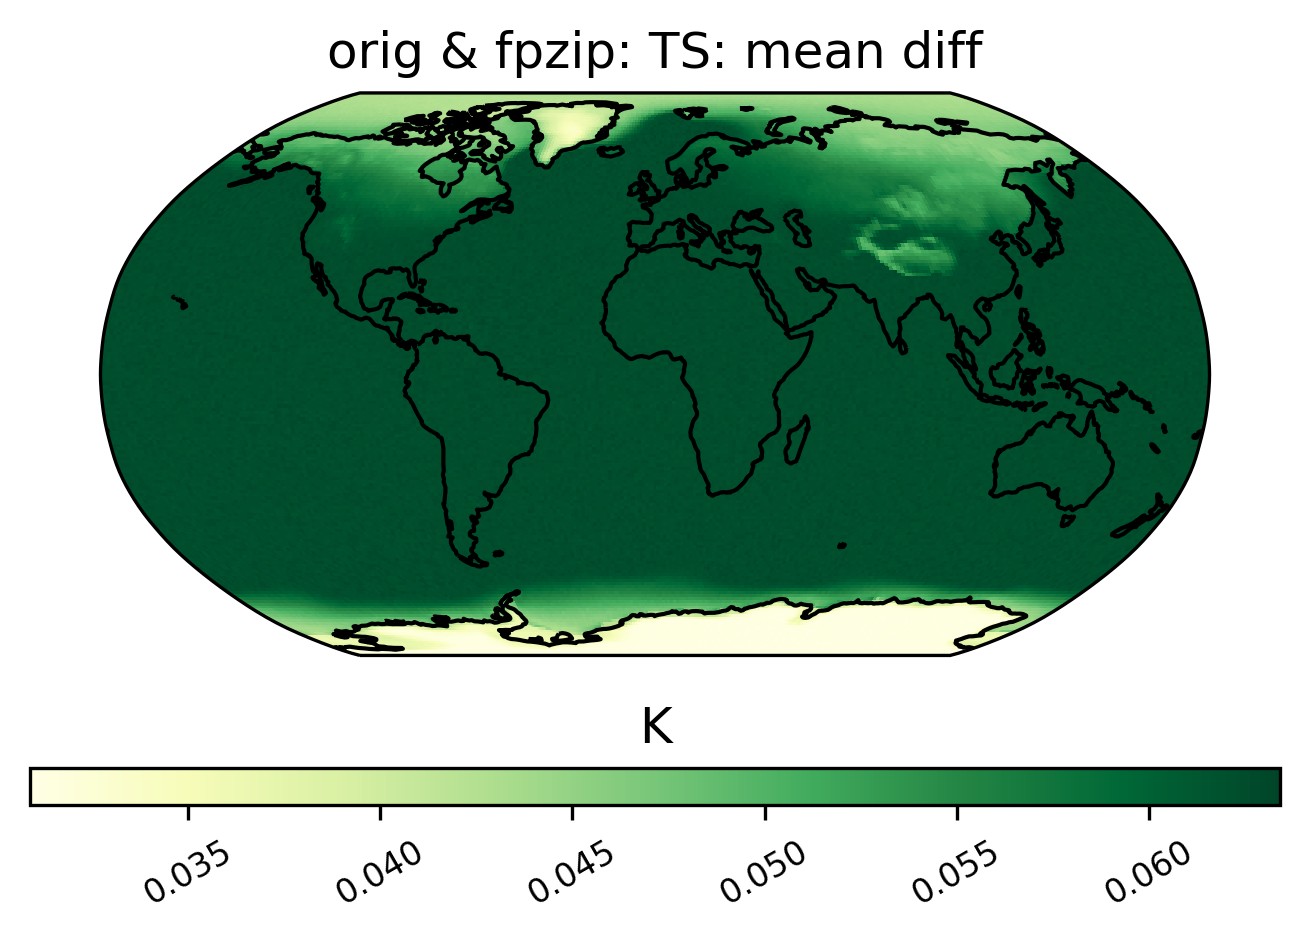

In [6]:
ldcpy.plot(
    col_TS_lens,
    "TS",
    sets=["orig", "fpzip"],
    calc="mean",
    calc_type="diff",
    color="YlGn",
)

In [7]:
# now load some TS data compressed with zfp 0.5.3 and sz compressors
col_TS_cageo = ldcpy.open_datasets(
    ["TS"],
    [
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/orig/b.e11.B20TRC5CNBDRD.f09_g16.030.cam.h1.TS.19200101-20051231.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/zfp1.0.TS.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/zfp0.1.TS.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/zfp0.01.TS.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/sz1.0.TS.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/sz0.1.TS.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/sz0.01.TS.nc",
    ],
    ["orig", "zfp1.0", "zfp0.1", "zfp0.01", "sz1.0", "sz0.1", "sz0.01"],
    chunks={"time": 500},
)
col_TS_cageo

dataset size in GB 48.60



,Array,Chunk
Bytes,48.60 GB,110.59 MB
Shape,"(7, 31390, 192, 288)","(1, 500, 192, 288)"
Count,1330 Tasks,441 Chunks
Type,float32,numpy.ndarray


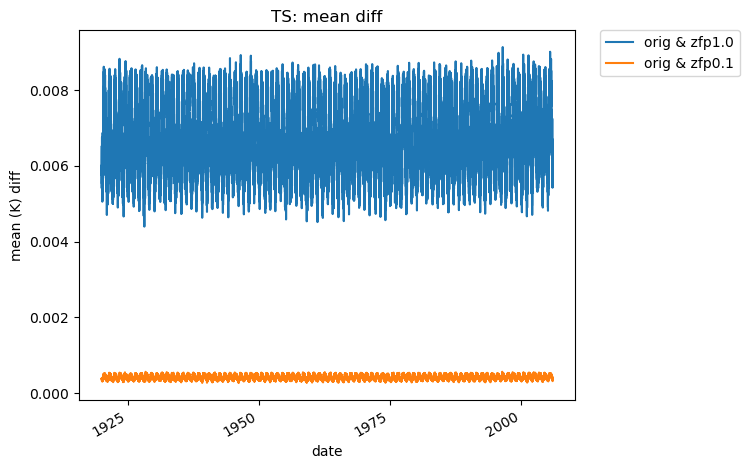

In [8]:
# Time-series plot of TS mean diff from orig with zfp 0.5.3
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "zfp1.0", "zfp0.1"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

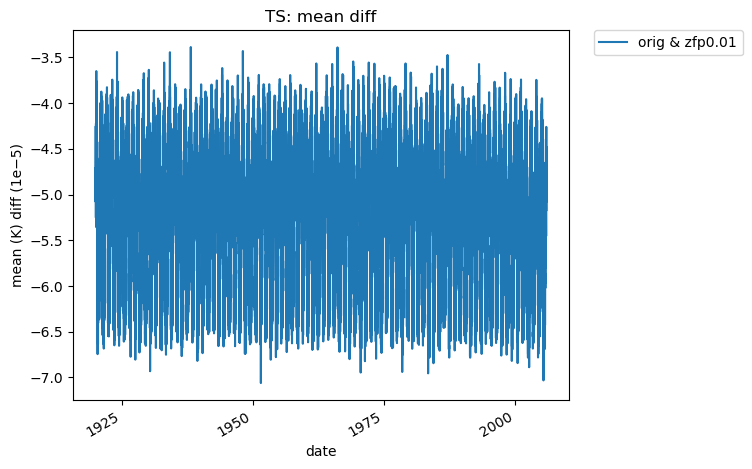

In [9]:
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "zfp0.01"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

You can see the average error at each time slice (above) is all postive for 1.0
and 0.1 tolerances. The tolerance 0.01 results in all negative error. If we look
at the corresponding spatial plots, we can see that there is negative error but
it is less widespread than the positive for 1.0 and 0.1 (and the opposite for
0.01). The reason for ZFP 0.5.3's behavior was explained in the paper referenced
above.


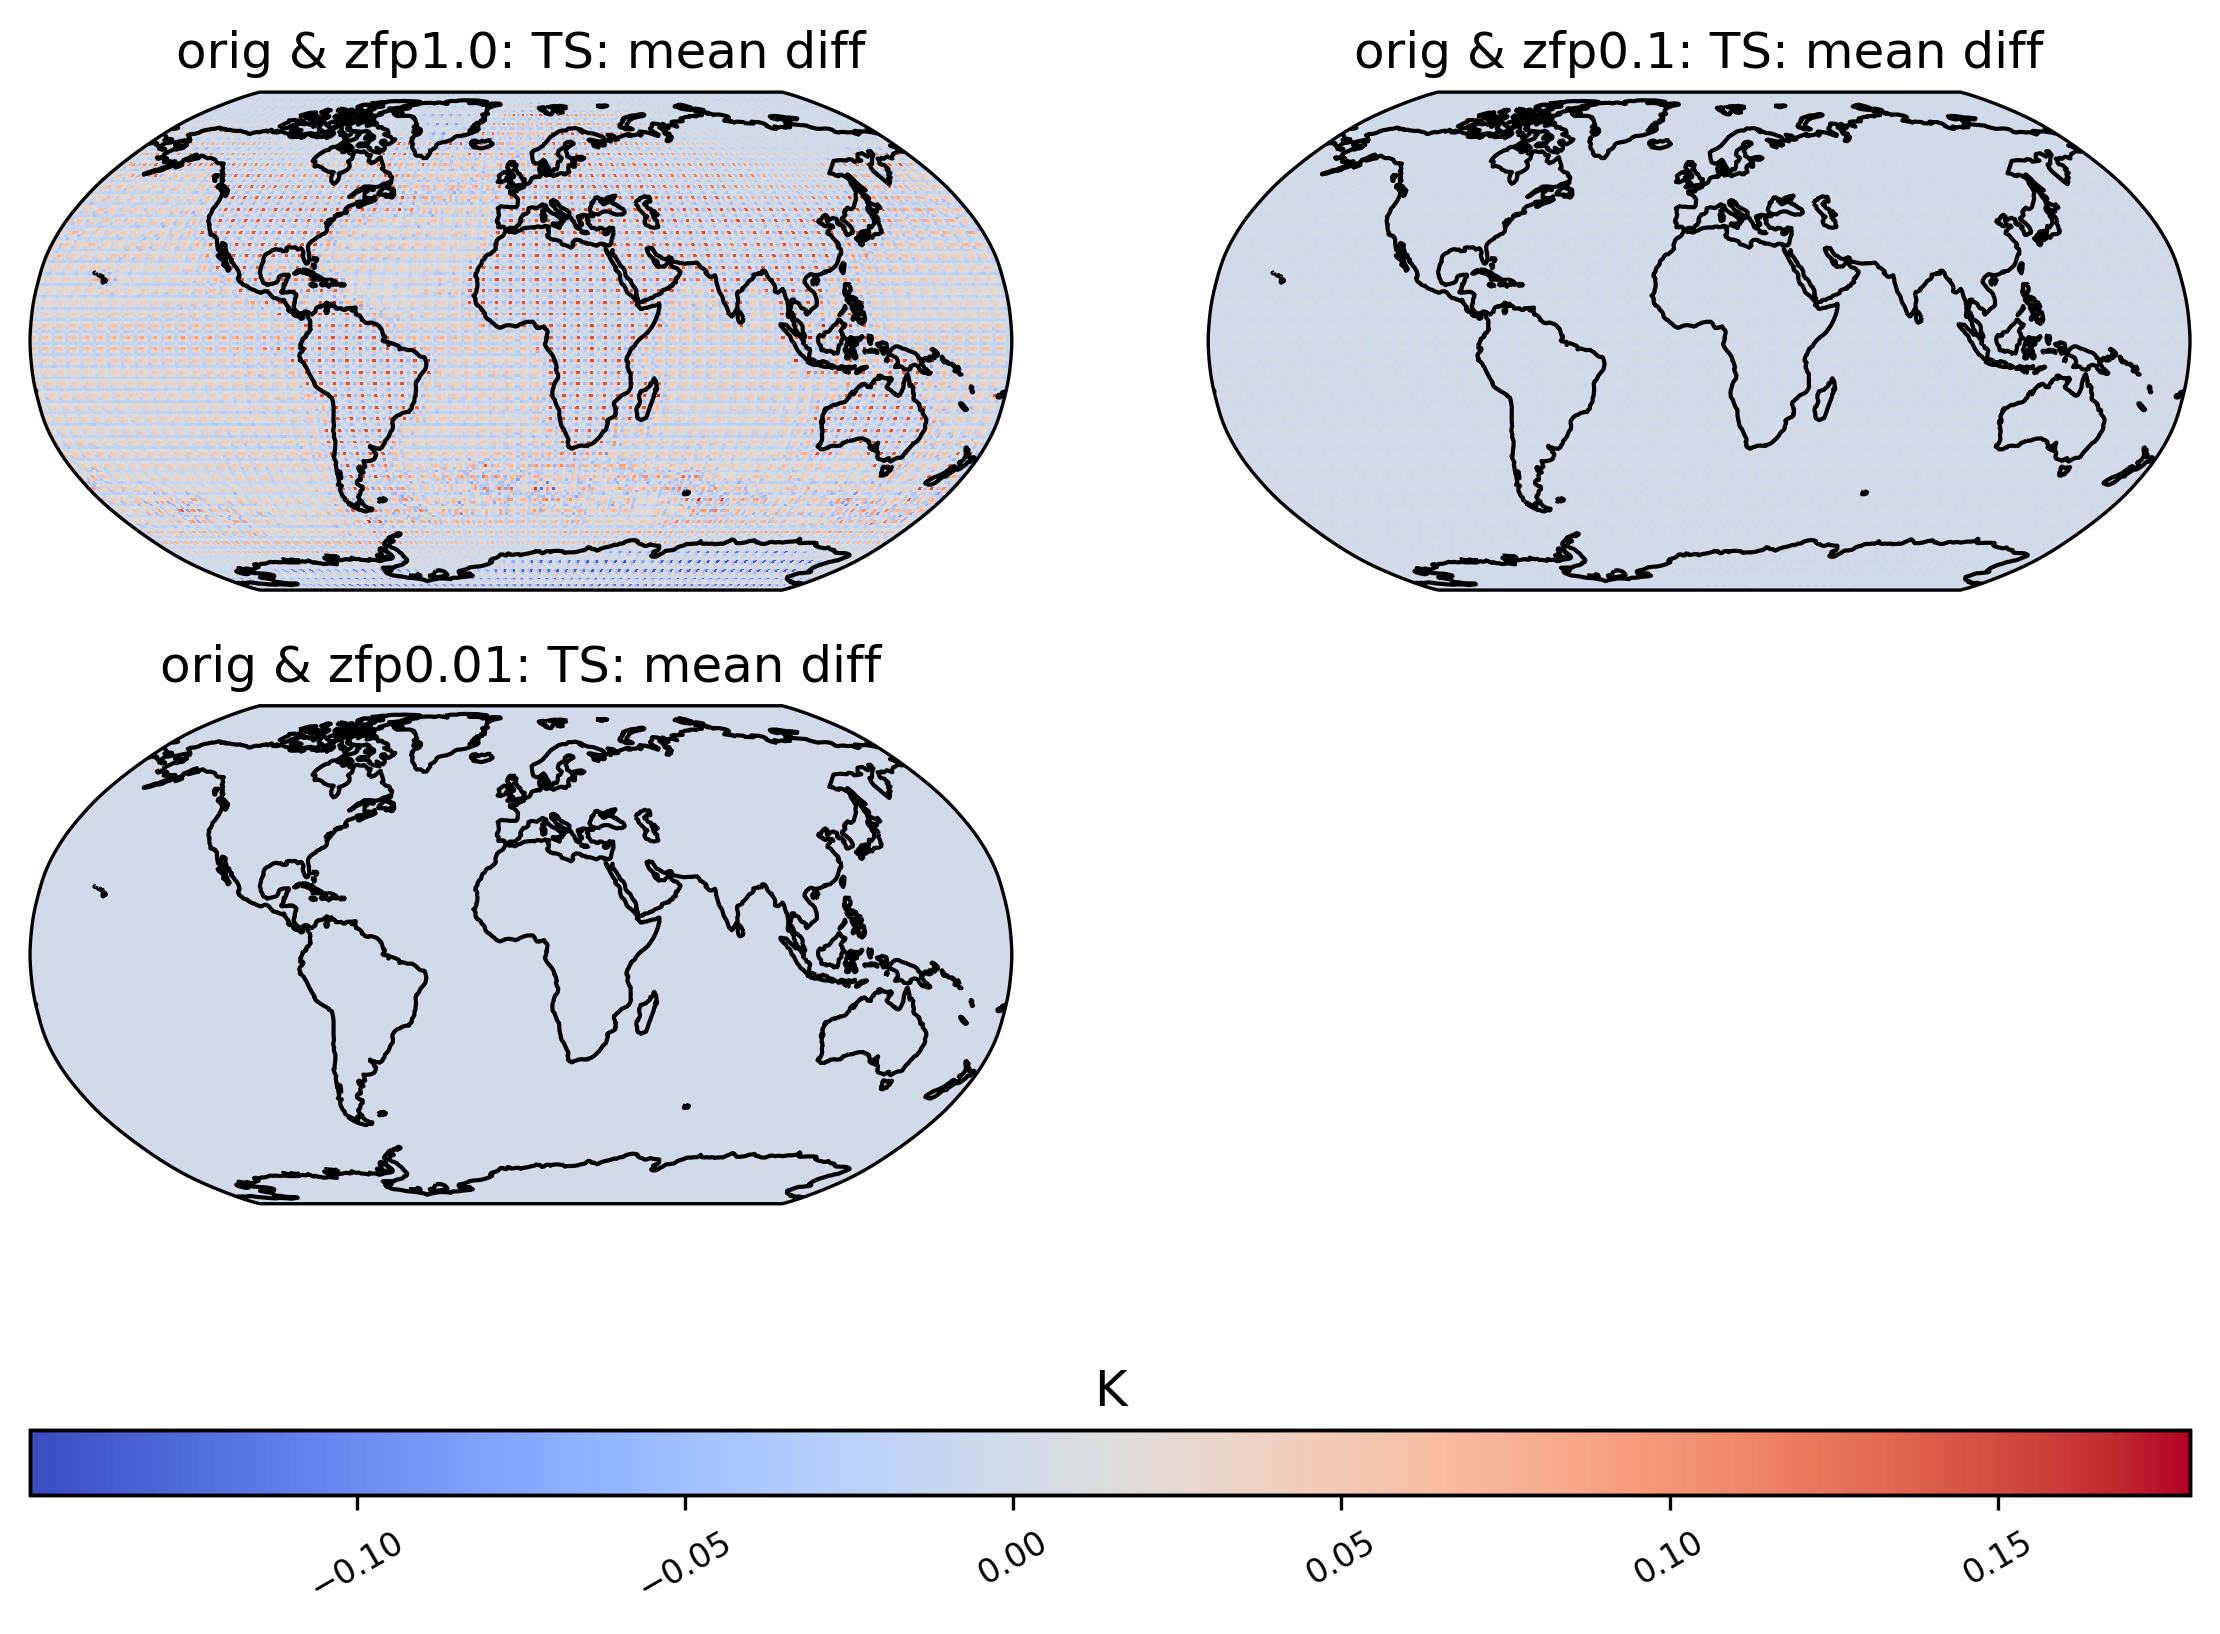

In [10]:
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "zfp1.0", "zfp0.1", "zfp0.01"],
    calc="mean",
    calc_type="diff",
)

When you do three plots together, they share the same color bar, so it may be
difficult to see features with the smaller tolerances. So we replot those below.


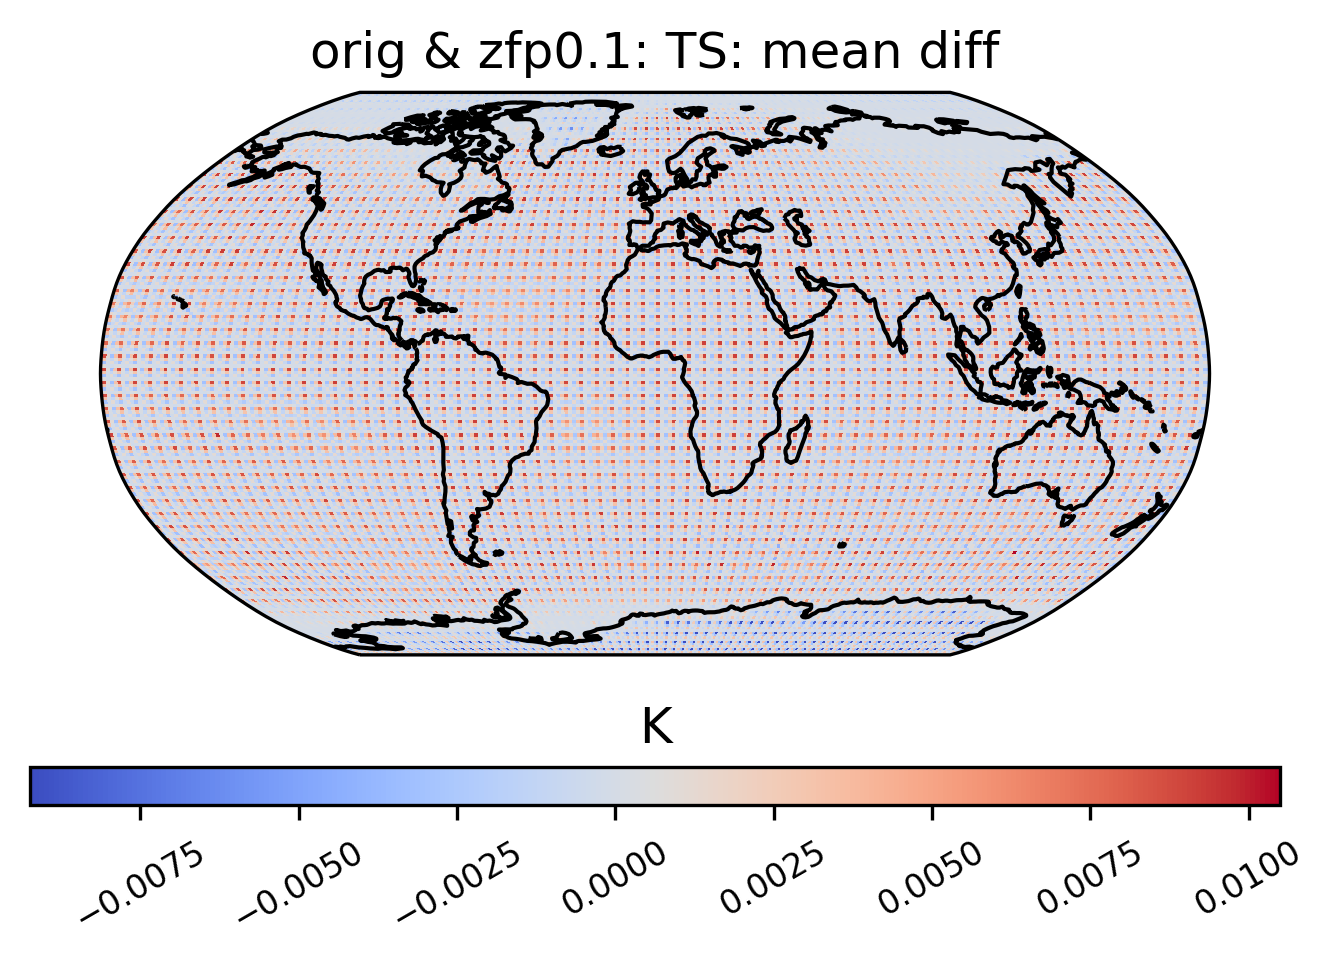

In [11]:
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "zfp0.1"],
    calc="mean",
    calc_type="diff",
)

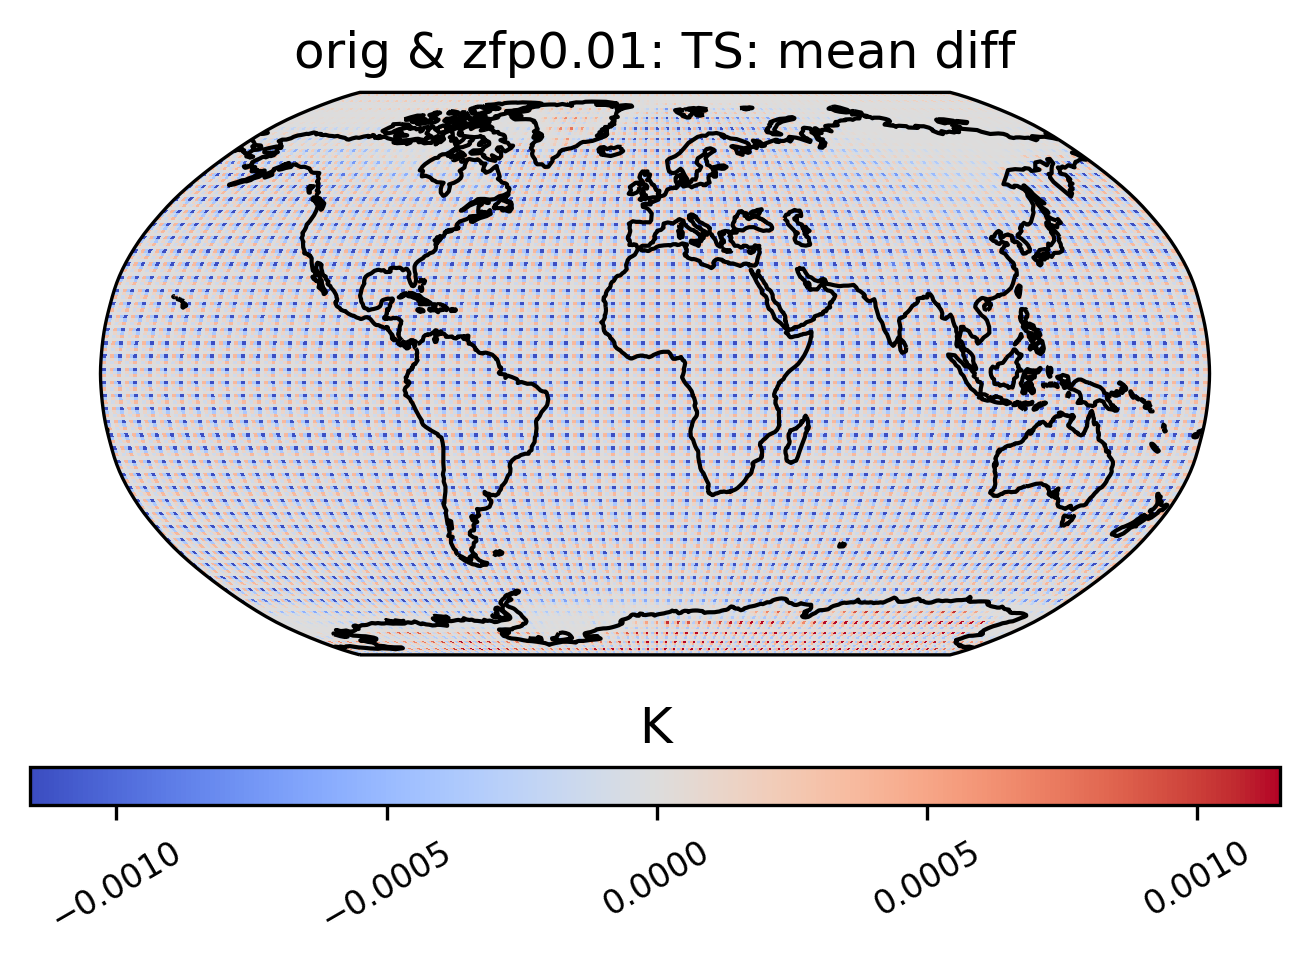

In [12]:
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "zfp0.01"],
    calc="mean",
    calc_type="diff",
)

Now we look at two other (improved) variants of zfp, called ZFP-beta and
ZFP-round.


In [13]:
col_TS_zfp = ldcpy.open_datasets(
    ["TS"],
    [
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/orig/b.e11.B20TRC5CNBDRD.f09_g16.030.cam.h1.TS.19200101-20051231.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpbeta1.0.TS.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpbeta0.1.TS.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpbeta0.01.TS.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpround1.0.TS.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpround0.1.TS.nc",
        "/glade/p/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpround0.01.TS.nc",
    ],
    [
        "orig",
        "zfpbeta1.0",
        "zfpbeta0.1",
        "zfpbeta0.01",
        "zfpround1.0",
        "zfpround0.1",
        "zfpround0.01",
    ],
    chunks={"time": 500},
)
col_TS_zfp

dataset size in GB 48.60



,Array,Chunk
Bytes,48.60 GB,110.59 MB
Shape,"(7, 31390, 192, 288)","(1, 500, 192, 288)"
Count,1330 Tasks,441 Chunks
Type,float32,numpy.ndarray


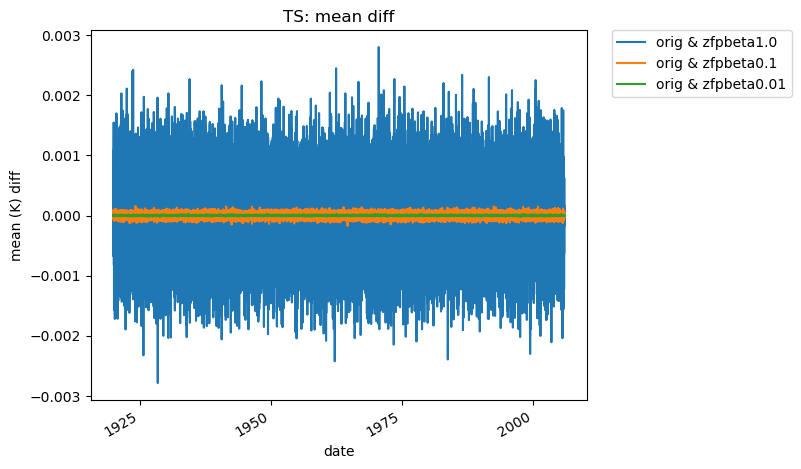

In [14]:
# zfp-beta
ldcpy.plot(
    col_TS_zfp,
    "TS",
    sets=["orig", "zfpbeta1.0", "zfpbeta0.1", "zfpbeta0.01"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

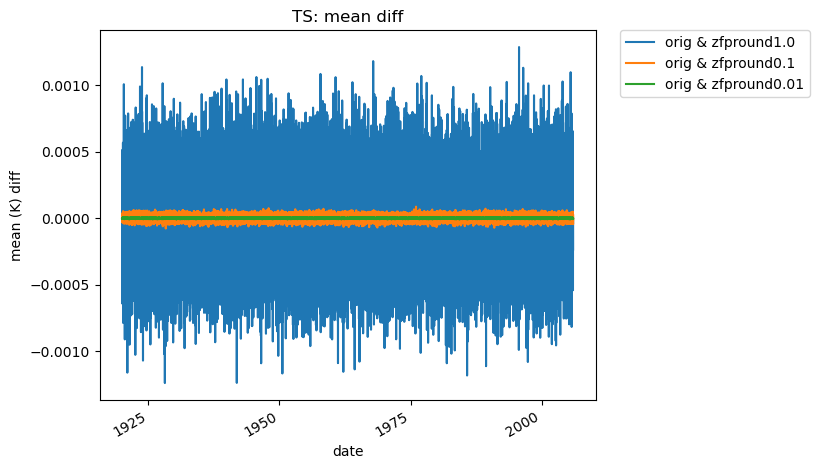

In [15]:
# zfp-round
ldcpy.plot(
    col_TS_zfp,
    "TS",
    sets=["orig", "zfpround1.0", "zfpround0.1", "zfpround0.01"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

Both of the above have an error distribution more like we would expect (mean ~ 0
). For comparison, we can plot the SZ compressor as well.


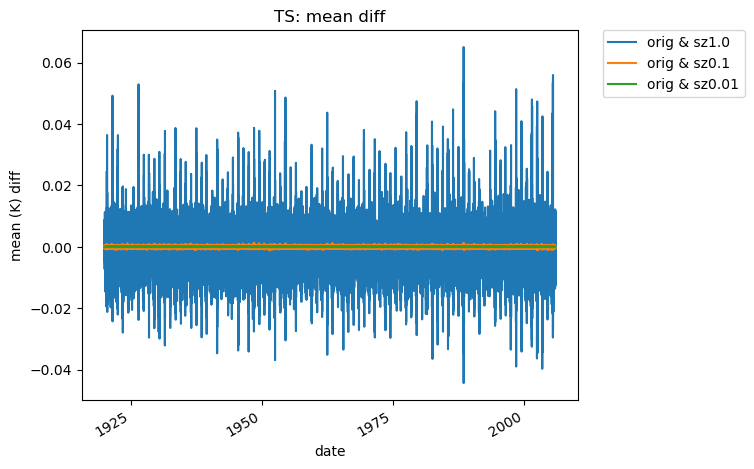

In [16]:
# Time-series plot of TS mean diff from orig with sz
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "sz1.0", "sz0.1", "sz0.01"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

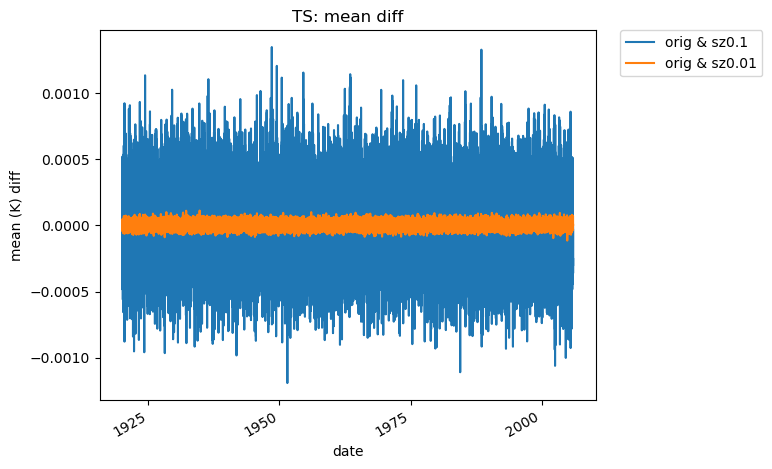

In [17]:
# same plot as above but just the smaller two tolerances
# Time-series plot of TS mean diff from orig with sz
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "sz0.1", "sz0.01"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

In [18]:
cluster.close()
client.close()